# Import Libs

In [2]:
import os
import sys

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression, SelectKBest
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

import xgboost as xgb


# Loading datasets and manual module

In [3]:
sys.path.append(os.path.abspath('./reg_for_human'))
from reg_for_human.random_forest import RandomForestRegressor as RFG

df_train = pd.read_csv('datasets/housing_dataset/train.csv')
df_test = pd.read_csv('datasets/housing_dataset/test.csv')

df_train.info()
df_train.describe()

categorical_columns = df_train.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_columns = df_train.select_dtypes(include=['number']).columns.tolist()

print("Categorical columns:", categorical_columns)
print("Numeric columns:", numeric_columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

# Data pre-processing

In [4]:
num_missing = df_train[numeric_columns].isnull().any()
cat_missing = df_train[categorical_columns].isnull().any()

print('Numeric columns with NaN:', df_train[numeric_columns].columns[num_missing].tolist())
print('Categorical columns with NaN:', df_train[categorical_columns].columns[cat_missing].tolist())

for col in categorical_columns:
    value_counts = df_train[col].value_counts()
    rare_categories = value_counts[value_counts < 50].index
    df_train[col] = df_train[col].replace(rare_categories, 'Other')
    df_train[col] = df_train[col].fillna('Other')

df_train = df_train[df_train['Utilities'] != 'Other']

# Target variable and feature separation
y = df_train['SalePrice']
X = df_train.drop(columns=['SalePrice', 'Id'], errors='ignore')


Numeric columns with NaN: ['LotFrontage', 'MasVnrArea', 'GarageYrBlt']
Categorical columns with NaN: ['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']


# Split data

In [6]:
X_train, X_test_full, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

median_value = X_train['LotFrontage'].median()
X_train['LotFrontage'] = X_train['LotFrontage'].fillna(median_value)
X_val['LotFrontage'] = X_val['LotFrontage'].fillna(median_value)
X_test_full['LotFrontage'] = X_test_full['LotFrontage'].fillna(median_value)

X_train['GarageYrBlt'] = X_train['GarageYrBlt'].fillna(0)
X_val['GarageYrBlt'] = X_val['GarageYrBlt'].fillna(0)
X_test_full['GarageYrBlt'] = X_test_full['GarageYrBlt'].fillna(0)

X_train['MasVnrArea'] = X_train['MasVnrArea'].fillna(X_train['MasVnrArea'].median())
X_val['MasVnrArea'] = X_val['MasVnrArea'].fillna(X_train['MasVnrArea'].median())
X_test_full['MasVnrArea'] = X_test_full['MasVnrArea'].fillna(X_train['MasVnrArea'].median())


ordered_columns = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'FireplaceQu', 'GarageQual', 'GarageCond']

columns_for_onehot = [col for col in categorical_columns if col not in ordered_columns and col in X_train.columns]

# Encode ordered categories
def encode_ordered(df, ref_df, cols):
    le = LabelEncoder()
    for c in cols:
        df[c] = le.fit(ref_df[c].astype(str))
    return df

for col in ordered_columns:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col].astype(str))
    X_val[col] = le.transform(X_val[col].astype(str))
    X_test_full[col] = le.transform(X_test_full[col].astype(str))

X_train = pd.get_dummies(X_train, columns=columns_for_onehot, drop_first=True)
X_val = pd.get_dummies(X_val, columns=columns_for_onehot, drop_first=True)
X_test_full = pd.get_dummies(X_test_full, columns=columns_for_onehot, drop_first=True)

X_train, X_val = X_train.align(X_val, join='left', axis=1, fill_value=0)
X_train, X_test_full = X_train.align(X_test_full, join='left', axis=1, fill_value=0)

bool_columns = X_train.select_dtypes(include=['bool']).columns
X_train[bool_columns] = X_train[bool_columns].astype(int)
X_val[bool_columns] = X_val[bool_columns].astype(int)
X_test_full[bool_columns] = X_test_full[bool_columns].astype(int)



# Feature selections

In [7]:
selector = SelectKBest(mutual_info_regression, k=5)
selector.fit(X_train, y_train)
selected_features = X_train.columns[selector.get_support()]

X_train = X_train[selected_features]
X_val = X_val[selected_features]
X_test = X_test_full[selected_features]

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

In [ ]:
# Model evaluation

In [9]:
def evaluate_model(model, X_train, X_test, y_train_scaled, y_test_scaled, X_train_scaled=None, X_test_scaled=None):
    # Predict on test set
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test_scaled, y_pred)
    r2 = r2_score(y_test_scaled, y_pred)
    print("RMSE:", np.sqrt(mse))
    print("Mean Squared Error (MSE):", mse)
    print("R² Score:", r2)

    # Train MSE
    y_train_pred = model.predict(X_train)
    train_mse = mean_squared_error(y_train_scaled, y_train_pred)
    print("Train MSE:", train_mse)
    print("Test MSE:", mse)
    print("Test/Train MSE Ratio:", mse / train_mse)

    return mse, r2

# Modeling

In [10]:
# --- Random Forest (sklearn)
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train_scaled)
print("Random Forest (sklearn) Results:")
evaluate_model(rf_regressor, X_train, X_test, y_train_scaled, y_test_scaled)

# --- Custom Random Forest
rf_reg1 = RFG()
rf_reg1.fit(X_train, y_train_scaled)
print("Custom Random Forest Results:")
evaluate_model(rf_reg1, X_train, X_test, y_train_scaled, y_test_scaled)

# --- Linear Regression
lr_regressor = LinearRegression()
lr_regressor.fit(X_train, y_train_scaled)
print("Linear Regression Results:")
evaluate_model(lr_regressor, X_train, X_test, y_train_scaled, y_test_scaled)

# --- XGBoost
model_xgb = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model_xgb.fit(X_train, y_train_scaled)
print("XGBoost Results:")
evaluate_model(model_xgb, X_train, X_test, y_train_scaled, y_test_scaled)

# --- SVR (with scaling of features)
scaler_features = StandardScaler()
X_train_scaled = scaler_features.fit_transform(X_train)
X_test_scaled = scaler_features.transform(X_test)

regressor_svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)
regressor_svr.fit(X_train_scaled, y_train_scaled)
print("SVR Results:")
evaluate_model(regressor_svr, X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled)


Random Forest (sklearn) Results:
RMSE: 0.3926057228741978
Mean Squared Error (MSE): 0.15413925363357142
R² Score: 0.8386883632781255
Train MSE: 0.02772365413440089
Test MSE: 0.15413925363357142
Test/Train MSE Ratio: 5.559846219633355
Custom Random Forest Results:
RMSE: 0.4320985959277835
Mean Squared Error (MSE): 0.1867091966027619
R² Score: 0.8046028809337764
Train MSE: 0.055303327465344644
Test MSE: 0.1867091966027619
Test/Train MSE Ratio: 3.3760933592967186
Linear Regression Results:
RMSE: 0.3936627590788979
Mean Squared Error (MSE): 0.15497036788561042
R² Score: 0.8378185757506861
Train MSE: 0.22205971507783762
Test MSE: 0.15497036788561042
Test/Train MSE Ratio: 0.6978770004784044
XGBoost Results:
RMSE: 0.4108558411653836
Mean Squared Error (MSE): 0.1688025222197149
R² Score: 0.8233427858242063
Train MSE: 0.06759513746896983
Test MSE: 0.1688025222197149
Test/Train MSE Ratio: 2.497258361183232
SVR Results:
RMSE: 0.3627672789740629
Mean Squared Error (MSE): 0.13160009869424558
R² Sco

(np.float64(0.13160009869424558), 0.8622763065688972)

# Plotting Results

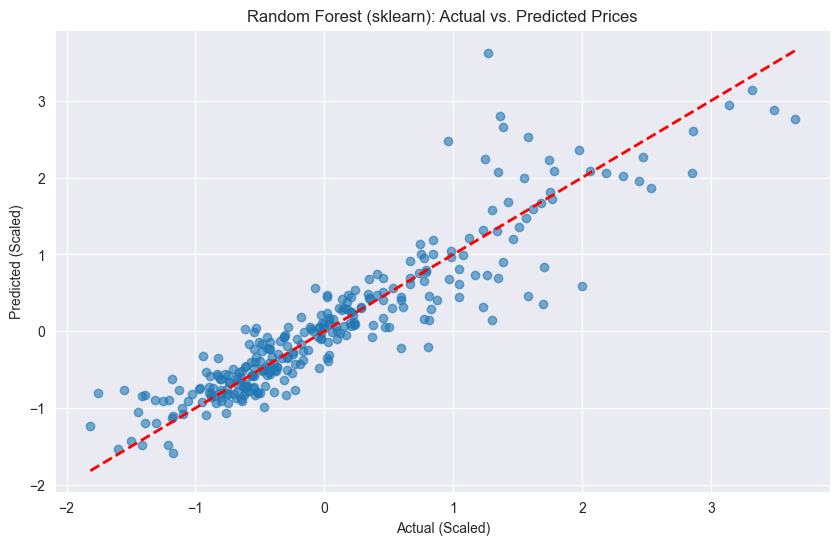

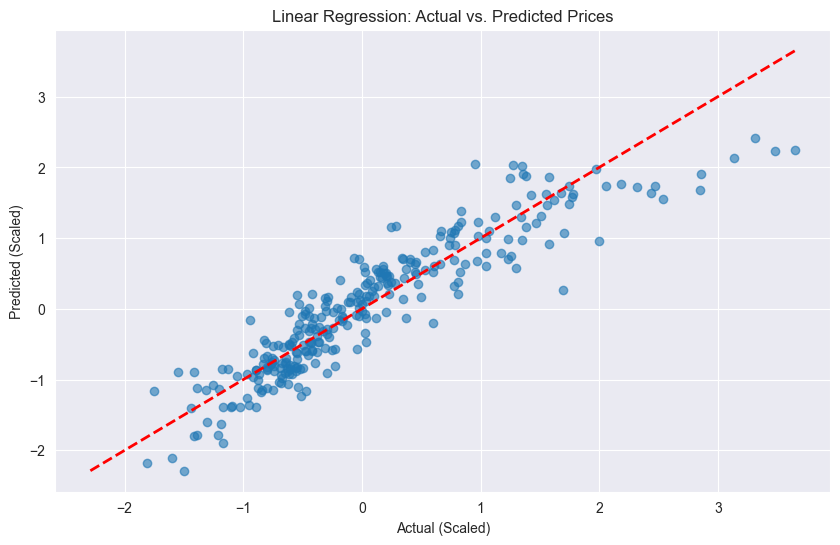

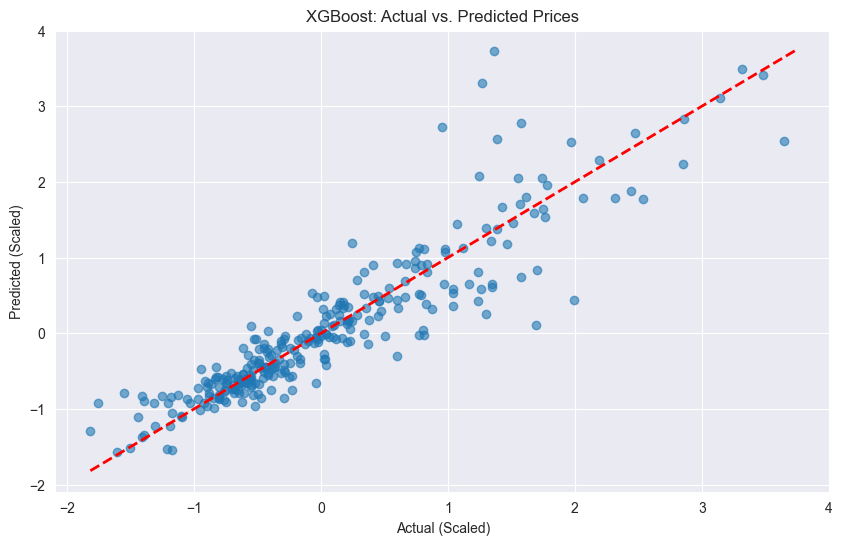

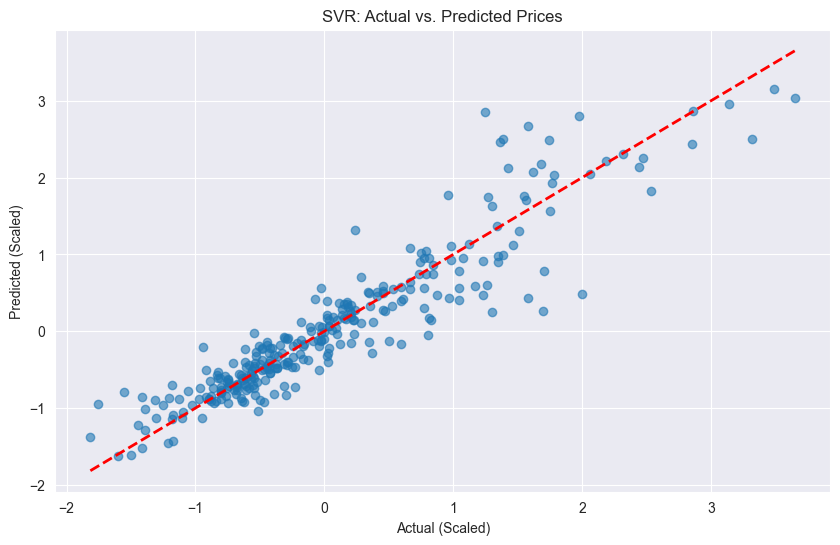

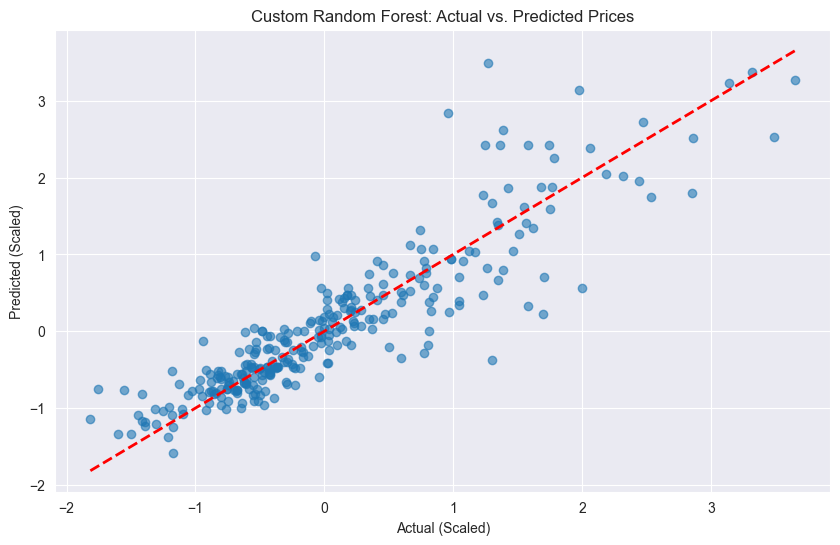

In [12]:
def plot_actual_vs_pred(y_true_scaled, y_pred, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true_scaled, y_pred, alpha=0.6)
    min_val = min(y_true_scaled.min(), y_pred.min())
    max_val = max(y_true_scaled.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    plt.title(title)
    plt.xlabel("Actual (Scaled)")
    plt.ylabel("Predicted (Scaled)")
    plt.show()

# Plot for Random Forest (sklearn)
y_pred_rf = rf_regressor.predict(X_test)
plot_actual_vs_pred(y_test_scaled, y_pred_rf, "Random Forest (sklearn): Actual vs. Predicted Prices")

# Plot for Linear Regression
y_pred_lr = lr_regressor.predict(X_test)
plot_actual_vs_pred(y_test_scaled, y_pred_lr, "Linear Regression: Actual vs. Predicted Prices")

# Plot for XGBoost
y_pred_xgb = model_xgb.predict(X_test)
plot_actual_vs_pred(y_test_scaled, y_pred_xgb, "XGBoost: Actual vs. Predicted Prices")

# Plot for SVR
y_pred_svr = regressor_svr.predict(X_test_scaled)
plot_actual_vs_pred(y_test_scaled, y_pred_svr, "SVR: Actual vs. Predicted Prices")

y_pred_rf1 = rf_reg1.predict(X_test)
plot_actual_vs_pred(y_test_scaled, y_pred_rf1, "Custom Random Forest: Actual vs. Predicted Prices")
